In [237]:
import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import cross_validate
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

import shinra_util as util
import bootstrap as bs
import word_entropy
import feature

import warnings
warnings.filterwarnings('ignore')

In [141]:
plt.rcParams['font.family'] = 'IPAGothic'

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with open("../data/compound_train.json") as f:
    train = json.load(f)['entry']

In [113]:
train_production_dict = util.train2dict(train, attribute="製造方法")

In [202]:
wiki_raw_data = util.read_jasonl("../data/jawiki-cirrussearch-dump_of_Compound.jsonl")

In [114]:
wiki_sentence_df = pd.read_csv("../data/wikitext_split_sentence.csv")

## Trainデータ作成

In [19]:
train_id = [str(entry['WikipediaID']) for entry in train]

In [123]:
train_sentence_df = wiki_sentence_df.loc[wiki_sentence_df._id.isin(train_id)].reset_index(drop=True)
train_sentence_df._id = train_sentence_df._id.astype(str)
train_sentence_df = util.labeling(train_sentence_df, train_production_dict)
train_sentence_df.head()

,_id,sentence,label
0,2662912,ハロン (halon) は、炭化水素の水素原子（一部または全て）がハロゲン原子で置換されたハ...,False
1,2662912,ハロゲン化炭化水素 (halogenated hydrocarbon) が語源で、アメリカ陸...,False
2,2662912,ハロン類 (halons)、ハロン化合物 (halon compounds) ともいう。,False
3,2662912,ハロンに対し、臭素を含まず、ハロゲンがフッ素と塩素のみの化合物を、フロン（クロロフルオロカー...,False
4,2662912,ただし、フロンが日本特有の語であるのに対し、ハロンは国際的に通用する名である。,False


In [125]:
train_sentence_df.loc[train_sentence_df.label == True, 'sentence'].values

array(['1837年にスーベイラン (Soubeiran) が二塩化硫黄のベンゼン溶液にアンモニアを通じることで初めて合成した。',
       '6 SCl2 ＋ 16 NH3 → N4S4 ＋ 2 S ＋ 12 NH4Cl 二塩化硫黄の四塩化炭素溶液に塩素を加え、アンモニアを通しても生ずる。',
       '4 SCl2 ＋ 16 NH3 ＋ 2 Cl2 → S4N4 ＋ 12 NH4Cl 二塩化二硫黄の二硫化炭素溶液にアンモニアを作用させてもできる。',
       '四硫化四窒素を真空中で 300 ℃ に加熱すると生じる。',
       '四硫化四窒素を硫黄とともに二硫化炭素中で混合させてオートクレーブ中 110 ℃ に加熱すると生じる。',
       '二硫化二窒素を真空中で長時間放置すると生じる。',
       '1,2-グリコール合成を工業的に合成する場合は、アルケンを空気酸化してオキシラン（エポキシド）とし、酸性条件下においてH2O で開環させてジオールとする。',
       '実験室的にはアルケンを四酸化オスミウムで酸化するか、アルケンを低温下で過マンガン酸カリウムと反応させてジオールを得る。',
       'N-メチル-2-ピロリドンは、γ-ブチロラクトンとメチルアミンとを縮合させて得る 高い溶解性を持つため、特に高分子化学の分野を中心に様々な物質に対する溶媒として用いられる。',
       '製法は氷冷したフッ化水素酸にアンモニアを通じて析出させるか、塩化アンモニウムとフッ化ナトリウムの混合物または硫酸アンモニウムとフッ化カルシウムの混合物を加熱し，昇華させて得る。',
       '製法は直接アンモニアとフッ化水素の反応生成物を加熱固化するか、同酸、塩基水溶液を混合し蒸発濃縮すると得られる。',
       'また、前述のように正塩を熱分解しても得られる。',
       'クロロホルムはフッ化水素と反応してクロロジフルオロメタンとなり、クロロジフルオロメタンが熱分解してTFEが生成する。',
       'CHCl3 + 2 HF → CHClF2 + 2 HCl 2 CHClF2 → C2F4 + 2 HCl 実験室的には、PTFEを減圧下で熱分解して製造する。',
       '初めて発見

## ブートストラップ法で手がかり語抽出→フィルタリング
- いまいち…

In [130]:
parsed_df = pd.read_pickle("../dump/parsed_df.pickle")

In [157]:
bs_model = bs.Bootstrap(parsed_df)
bs_model.run(['得られる'])

loop:  1
clue words count:  50
loop:  2
clue words count:  59
loop:  3
clue words count:  59


In [137]:
bs_model.clue_words

['見られる',
 '行う',
 'ない',
 '変換される',
 '合成される',
 '高い',
 '一つ',
 '示す',
 'できる',
 '呼ばれる',
 'ある',
 '阻害する',
 '使用される',
 'した',
 '引き起こす',
 '化合物である',
 '利用される',
 '生成する',
 '多い',
 '用いられる',
 'なった',
 'なっている',
 '一種である',
 '用いられている',
 'ことが',
 '表される',
 'あり',
 '指定されている',
 '得られる',
 '発生する',
 'ことで',
 '存在する',
 '用いる',
 'なる',
 '与える',
 '作る',
 '持つ',
 'されている',
 'ため',
 '含む',
 '有する',
 '含まれる',
 '分解する',
 '生成される',
 'する',
 '生じる',
 '一種',
 '分類される',
 '得る',
 '該当する',
 'ために',
 '承認された',
 '知られている',
 '形成する',
 '使われる',
 'なり',
 '合成する',
 '報告されている',
 '一つである']

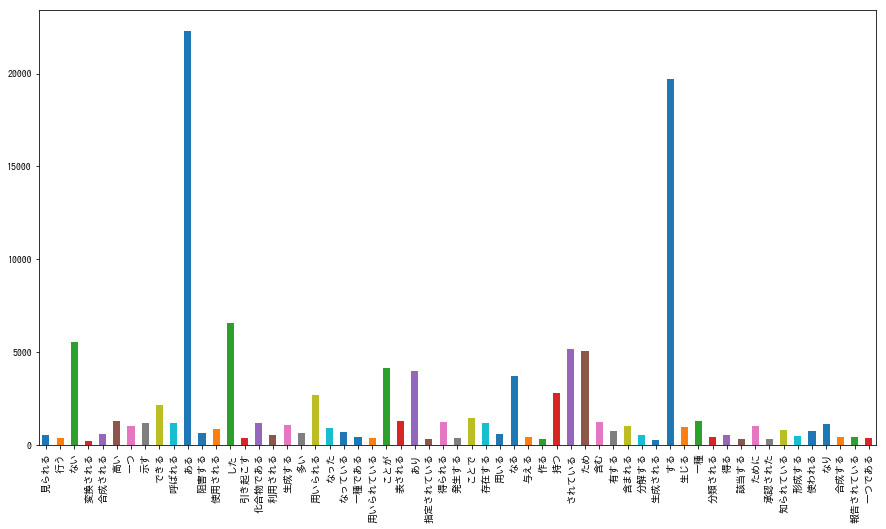

In [158]:
feature_word_dict = {}
for word in bs_model.clue_words:
    feature_word_dict[word] = wiki_sentence_df.sentence.str.contains(util.contains_patt(word)).tolist()

pd.DataFrame(feature_word_dict).T.apply(lambda x: sum(x), axis=1).plot(kind='bar', figsize=(15, 8))

In [159]:
BS_clue_words = bs_model.clue_words.copy()
remove_words = ["ない", "できる", "ある", "した", "ことが", "あり", "ことで", "なる", "されている", "ため", "する", "ために", "なり"]
[BS_clue_words.remove(v) for v in remove_words]

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [160]:
# ブートストラップ法で得た手がかり語で学習データをフィルタリング
print("train length :", len(train_sentence_df))
print("label 1 :", len(train_sentence_df.loc[train_sentence_df.label == 1]), "\tlabel 0 :", len(train_sentence_df.loc[train_sentence_df.label == 0]))

filtering_train_sentence_df = train_sentence_df.loc[train_sentence_df.sentence.str.contains(util.contains_patt(BS_clue_words))].reset_index(drop=True)
print("train length (filtering) :", len(filtering_train_sentence_df))
print("label 1 :", len(filtering_train_sentence_df.loc[filtering_train_sentence_df.label == 1]), "\tlabel 0 :", len(filtering_train_sentence_df.loc[filtering_train_sentence_df.label == 0]))

train length : 8929
label 1 : 500 	label 0 : 8429
train length (filtering) : 3561
label 1 : 306 	label 0 : 3255


## Entropyを用いた手がかり語抽出

In [164]:
is_clue_word = lambda hinshi: (hinshi[0] == "名詞" and hinshi[1] == "サ変接続") or (hinshi[0] == "動詞" and hinshi[1] == "自立")

In [174]:
clue_word_df = \
train_sentence_df.assign(
    clue_word = 
    train_sentence_df.apply(
        lambda x: util.get_word_list(x.sentence, is_clue_word)
        , axis=1
    )
)[["clue_word", "label"]]

In [176]:
clue_word_entropy = word_entropy.word_entropy(clue_word_df)

/Users/dontsentouin/research/shinra/notebook/word_entropy.py:9: RuntimeWarning: invalid value encountered in true_divide
  return pd.Series(word_count / np.sum(word_count))
/Users/dontsentouin/research/shinra/notebook/word_entropy.py:12: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.nan_to_num(-word_proba * np.log2(word_proba)))


In [218]:
alpha = 1.1
entropy_clue_words = \
clue_word_entropy[
    (clue_word_entropy.entropy_positive > alpha * clue_word_entropy.entropy_negative) & (clue_word_entropy.entropy_negative > 0)
].clue_word.tolist()
entropy_clue_words

['析出',
 '加熱',
 '抽出',
 '熱',
 '合成',
 '濃縮',
 '作ら',
 '還元',
 '冷却',
 '反応',
 '加える',
 '通じ',
 '中和',
 '合さ',
 '溶かし',
 '脱',
 '沈殿',
 '得',
 '生成',
 '通す',
 '発酵',
 '得る',
 '蒸発']

## 特徴量作成

In [235]:
train_y = train_sentence_df.label.tolist()

In [ ]:
# Entropyで得た手がかり語が文中に含まれているかどうか
train_X = feature.contains_clue_word(train_sentence_df, entropy_clue_words + ['製造'])

# サブタイトル中にEntropyで得た手がかり語が含まれているかどうか
train_X["subtitle_cat"] = feature.subtitle_cat(train_sentence_df, entropy_clue_words + ['製造'])

In [290]:
category_in_NITE_df = pd.read_csv("../data/NITE_existence_list.csv")
category_in_NITE_list = category_in_NITE_df.loc[category_in_NITE_df.label == True].category.tolist()
compound_list = pd.read_csv("../data/compound_list.csv").rename(columns={"compound": "name"}).name.tolist()
element_list = pd.read_csv("../data/element_list.csv").name.tolist()

train_X["n_NITE"] = train_sentence_df.sentence.str.findall(util.contains_patt(category_in_NITE_list)).apply(lambda x: len(x))
train_X["n_compound"] = train_sentence_df.sentence.str.findall(util.contains_patt(compound_list)).apply(lambda x: len(x))
train_X["n_element"] = train_sentence_df.sentence.str.findall(util.contains_patt(element_list)).apply(lambda x: len(x))

## 学習

In [291]:
model = lgb.LGBMClassifier(is_unbalance=False)

scores = cross_validate(model, train_X, train_y, scoring=['f1', 'precision', 'recall'], cv=5)

print("f1: ", scores['test_f1'].mean())
print("precision: ", scores['test_precision'].mean())
print("recall: ", scores['test_recall'].mean())

f1:  0.46876935507351325
precision:  0.6305089699697543
recall:  0.378


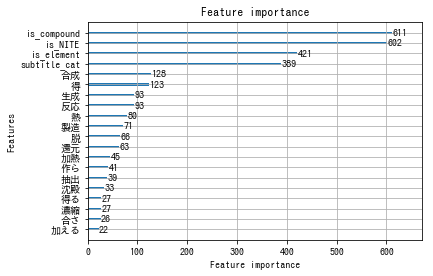

In [292]:
model.fit(train_X, train_y)
lgb.plot_importance(model)

In [284]:
predict = model.predict(train_X)

TP_index = np.where((predict == train_y) & (predict == 1))[0]
TN_index = np.where((predict == train_y) & (predict == 0))[0]
FP_index = np.where((predict != train_y) & (predict == 1))[0]
FN_index = np.where((predict != train_y) & (predict == 0))[0]

print("TP: ", len(TP_index))
print("TN: ", len(TN_index))
print("FP: ", len(FP_index))
print("FN: ", len(FN_index))

TP:  281
TN:  8391
FP:  38
FN:  219


In [288]:
print(train_sentence_df.loc[FP_index, 'sentence'].values)

['ゆえに濃縮することはできず、商業的に合成することはできない。'
 'ベンジルなど、他の 1,2-ジケトンからも同様のグリオキシム配位子が得られる。'
 'トリエチルアルミニウムを用い、ヘキシル鎖が生じたところで酸化処理すると 1-ヘキサノールが得られる。'
 'この手法ではヘキサノールの位置異性体を含む混合物が得られ、それぞれ可塑剤の原料として利用される。'
 '製造過程において水分を完全に除去するのが困難であり、市販品はKOH含有量85%程度のものが多く、無水物と一水和物（KOH·H2O）との混合物であり、多少の炭酸カリウムも含まれる。'
 '次世代のスチレン製造法として、トルエンとメタノールに塩基性ゼオライト触媒を作用させる方法が研究されている。'
 '炭酸銅(II)の正塩 CuCO3 は知られていない、とする辞典もあるが、高温高圧のCO2雰囲気下で三方晶系または単斜晶系の CuCO3 を塩基性塩から合成できる、という報告もある。'
 "9,9'-ジメチルキサンテンをsec-ブチルリチウムでジリチオ化し、クロロジフェニルホスフィンで処理することによって合成される。"
 '植物ではキシログルカンのフコース転移酵素が初めにクローニングされ、セルロースを除く植物細胞壁多糖類合成酵素初のクローニング例となった。'
 'トリメチルシリルエノールエーテルは、強塩基とクロロトリメチルシラン、または弱塩基とトリメチルシリルトリフラートの存在下でケトンから合成できる。'
 'シランの合成法としては使われなくなったが、ジシランの発生法としては利用される。'
 "（反応式） 5,10-メチレンテトラヒドロ葉酸 + デオキシウリジン一リン酸（dUMP） + FADH2 ⇌ チミジル酸（dTMP） + ジヒドロ葉酸 + FAD なお、DNAの合成は、dUMP（デオキシウリジン一リン酸）－dTMP（チミジル酸）－dTDP（チミジン二リン酸）－dTTP（チミジン三リン酸）と進み、リン酸2分子分のピロリン酸が遊離して、チミジル酸に相当する部分がDNA鎖のデオキシリボースの3'位に結合することで、アデニン、グアニン、シトシン、チミンと4種類あるDNA塩基のうちのチミンが完成する。"
 '炭酸水素カルシウムが一時硬水の成分であるのに対し、硫酸カルシウムを含有する天然水は加熱しても沈殿除去されな